In [ ]:
#!pip install fairlearn
#pip install raiwidgets
from google.colab import drive
import pandas as pd
import numpy as np
import sklearn
from sklearn import linear_model
from sklearn import model_selection
from sklearn import ensemble
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics 
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from sklearn.model_selection import train_test_split, StratifiedKFold, validation_curve, cross_val_score, GridSearchCV

# Data Loading

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Capstone/ipinyou/Data Modeling/final_training_testing.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head(2)
sorted_df=df.sort_values(by='Timestamp_bid', ascending=True)

NameError: ignored

In [ ]:
sorted_df.shape

(700000, 69)

In [ ]:
sorted_df.Timestamp_bid.iloc[199999]

20130607234418776

In [ ]:
sorted_df.Timestamp_bid.iloc[200000]

20130608000103260

In [ ]:
sorted_df['exact_time']=pd.to_datetime(sorted_df['Timestamp_bid'], format='%Y%m%d%H%M%S%f')

In [ ]:
sorted_df.head()

,Timestamp_bid,User-Agent_bid,Region ID_bids_join_impressions,City ID,Ad Exchange,Ad Slot Width,Ad Slot Height,Ad Slot Visibility,Ad Slot Format,Ad Slot Floor Price,Bidding Price,Advertiser ID,User Profile IDs_bid,Timestamp_imp,User-Agent_imp,Log Type,Paying Price,User Profile IDs_imp,n_impressions,Timestamp,User-Agent,User Profile IDs,Region ID_clicks,n_clicks,has impression,has click,10006,10024,10031,10048,10052,10057,10059,10063,10067,10074,10075,10076,10077,10079,10083,10093,10102,10110,10111,10684,11092,11278,11379,11423,11512,11576,11632,11680,11724,11944,13042,13403,13496,13678,13776,13800,13866,13874,14273,16593,16617,16661,16706,exact_time
0,20130606000104118,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,80,85,2,336,280,2,0,5,300,3386,NaN,2.013061e+16,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,1.0,5.0,"10063,10059,13776,10111",1.0,NaN,NaN,NaN,NaN,NaN,1,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013-06-06 00:01:04.118
4,20130606000104127,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,15,23,2,300,250,2,0,5,238,3358,NaN,2.013061e+16,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,1.0,126.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-06-06 00:01:04.127
11,20130606000104359,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.1...,80,81,2,336,280,2,0,5,238,3358,NaN,2.013061e+16,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.1...,1.0,72.0,"10059,10048,10093,10006,10031,10063,10075,1007...",1.0,NaN,NaN,NaN,NaN,NaN,1,0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013-06-06 00:01:04.359
18,20130606000104438,mozilla/4.0 (compatible; msie 7.0; windows nt ...,94,100,1,300,250,1,1,0,227,3358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-06-06 00:01:04.438
20,20130606000104460,mozilla/5.0 (compatible; msie 9.0; windows nt ...,333,341,1,300,250,2,1,0,227,3358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-06-06 00:01:04.460


# Train Test Split


## Questions
- 100,000 records per day or should we do otherwise? 
- random sampling or keep the same distribution in bids/impressions/clicks

## Train test split

In [ ]:
train=sorted_df.iloc[0:500000]
test=sorted_df.iloc[500000:]
print('train:', train.shape
      , '\ntest: ', test.shape )

train: (500000, 70) 
test:  (200000, 70)


In [ ]:
train.head()

,Timestamp_bid,User-Agent_bid,Region ID_bids_join_impressions,City ID,Ad Exchange,Ad Slot Width,Ad Slot Height,Ad Slot Visibility,Ad Slot Format,Ad Slot Floor Price,Bidding Price,Advertiser ID,User Profile IDs_bid,Timestamp_imp,User-Agent_imp,Log Type,Paying Price,User Profile IDs_imp,n_impressions,Timestamp,User-Agent,User Profile IDs,Region ID_clicks,n_clicks,has impression,has click,10006,10024,10031,10048,10052,10057,10059,10063,10067,10074,10075,10076,10077,10079,10083,10093,10102,10110,10111,10684,11092,11278,11379,11423,11512,11576,11632,11680,11724,11944,13042,13403,13496,13678,13776,13800,13866,13874,14273,16593,16617,16661,16706,exact_time
0,20130606000104118,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,80,85,2,336,280,2,0,5,300,3386,NaN,2.013061e+16,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,1.0,5.0,"10063,10059,13776,10111",1.0,NaN,NaN,NaN,NaN,NaN,1,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013-06-06 00:01:04.118
4,20130606000104127,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,15,23,2,300,250,2,0,5,238,3358,NaN,2.013061e+16,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,1.0,126.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-06-06 00:01:04.127
11,20130606000104359,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.1...,80,81,2,336,280,2,0,5,238,3358,NaN,2.013061e+16,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.1...,1.0,72.0,"10059,10048,10093,10006,10031,10063,10075,1007...",1.0,NaN,NaN,NaN,NaN,NaN,1,0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013-06-06 00:01:04.359
18,20130606000104438,mozilla/4.0 (compatible; msie 7.0; windows nt ...,94,100,1,300,250,1,1,0,227,3358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-06-06 00:01:04.438
20,20130606000104460,mozilla/5.0 (compatible; msie 9.0; windows nt ...,333,341,1,300,250,2,1,0,227,3358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-06-06 00:01:04.460


train.head()

In [ ]:
print(max(train.Timestamp_bid))
print(min(test.Timestamp_bid))

20130610234012042
20130611000102916


# I. Bids to impressions

## I.1. X1 & y1
- features: data from bids
- target: impression or not

In [ ]:
features1=['exact_time'
  , 'User-Agent_bid'
  , 'Region ID_bids_join_impressions'
  , 'City ID'	
  , 'Ad Exchange'
  ,	'Ad Slot Width'	
  , 'Ad Slot Height'	
  , 'Ad Slot Visibility'	
  , 'Ad Slot Format'	
  , 'Ad Slot Floor Price'	
  , 'Bidding Price'
  , 'Advertiser ID'  

  ]

target1='has impression'

In [ ]:
X1_train=train[features1]
X1_test=test[features1]

y1_train=train[target1]
y1_test=test[target1]
print('X_train:', X1_train.shape
      , '\nX_test: ', X1_test.shape 
      , '\ny_train:', y1_train.shape
      , '\ny_test: ', y1_test.shape)

NameError: ignored

In [ ]:
X1_train.head()

,Region ID_bids_join_impressions,City ID,Ad Exchange,Ad Slot Width,Ad Slot Height,Ad Slot Visibility,Ad Slot Format,Ad Slot Floor Price,Bidding Price,Advertiser ID
0,80,85,2,336,280,2,0,5,300,3386
4,15,23,2,300,250,2,0,5,238,3358
11,80,81,2,336,280,2,0,5,238,3358
18,94,100,1,300,250,1,1,0,227,3358
20,333,341,1,300,250,2,1,0,227,3358


## I.2 Baseline Model
- Predict the empirical probability
- calculate the entropy for such prediction

In [ ]:
y1_train.value_counts() 

0    385870
1    114130
Name: has impression, dtype: int64

In [ ]:
y1_train_result = y1_train.to_frame()['has impression'].value_counts()
emperical = y1_train_result[1]/len(y1_train)

In [ ]:
y1_test_baselinePredict = np.repeat(emperical,len(y1_test))
y1_test_baselinePredict

array([0.22826, 0.22826, 0.22826, ..., 0.22826, 0.22826, 0.22826])

the empirical probability is 0.22826.  Predicting 0.22826 for all the testing data points, the cross entropy (log loss) is 0.6774367

In [ ]:
sklearn.metrics.log_loss(y1_test, y1_test_baselinePredict) 

0.6774367146556441

## I.3. Logistic Regression
Questions 
- Algorithm not converging?

Deal with the city ID categorical feature by selecting the city ID that contributes to the most number of impression

In [ ]:
hasImpression = df[df['has impression']==1]
cityIDranking = hasImpression.groupby(['City ID']).size().sort_values(ascending=False)
cityIDranking[0:5].index

Int64Index([1, 219, 217, 79, 275], dtype='int64', name='City ID')

In [ ]:
X1_train_log = X1_train
X1_test_log = X1_test


Drop user-agent_bid as we assume this will have no impact on the ad slot information that agencies receive

In [ ]:
X1_train_log=X1_train_log.drop(['User-Agent_bid'],axis=1)

X1_test_log=X1_test_log.drop(['User-Agent_bid'],axis=1)

In [ ]:
X1_test_log.shape[1]==X1_train_log.shape[1]

True

Deal with the most commonly appearing city for both training set and test set

In [ ]:
X1_train_log['city1']=np.where(X1_train_log['City ID']==1,1,0)
X1_train_log['city219']=np.where(X1_train_log['City ID']==219,1,0)
X1_train_log['city217']=np.where(X1_train_log['City ID']==217,1,0)
X1_train_log['city79']=np.where(X1_train_log['City ID']==79,1,0)
X1_train_log['city215']=np.where(X1_train_log['City ID']==215,1,0)
X1_train_log=X1_train_log.drop('City ID',axis=1)

X1_test_log['city1']=np.where(X1_test_log['City ID']==1,1,0)
X1_test_log['city219']=np.where(X1_test_log['City ID']==219,1,0)
X1_test_log['city217']=np.where(X1_test_log['City ID']==217,1,0)
X1_test_log['city79']=np.where(X1_test_log['City ID']==79,1,0)
X1_test_log['city215']=np.where(X1_test_log['City ID']==215,1,0)

X1_test_log=X1_test_log.drop('City ID',axis=1)



In [ ]:
X1_test_log.shape[1]==X1_train_log.shape[1]

True

In [ ]:
X1_train_log['hour'] = pd.DatetimeIndex(X1_train_log['exact_time']).hour

X1_test_log['hour'] = pd.DatetimeIndex(X1_test_log['exact_time']).hour

In [ ]:
X1_train_log['timeframe_early_morning']=np.where((X1_train_log['hour']>=2) & (X1_train_log['hour']<7),1,0)
X1_train_log['timeframe_morning']=np.where((X1_train_log['hour']>=7) & (X1_train_log['hour']<12),1,0)
X1_train_log['timeframe_afternoon']=np.where((X1_train_log['hour']>=12) & (X1_train_log['hour']<18),1,0)

X1_test_log['timeframe_early_morning']=np.where((X1_test_log['hour']>=2) & (X1_test_log['hour']<7),1,0)
X1_test_log['timeframe_morning']=np.where((X1_test_log['hour']>=7) & (X1_test_log['hour']<12),1,0)
X1_test_log['timeframe_afternoon']=np.where((X1_test_log['hour']>=12) & (X1_test_log['hour']<18),1,0)

X1_train_log=X1_train_log.drop(['exact_time'],axis=1)
X1_test_log=X1_test_log.drop(['exact_time'],axis=1)

In [ ]:
X1_train_log=X1_train_log.drop(['hour','Advertiser ID','Region ID_bids_join_impressions'],axis=1)
X1_test_log=X1_test_log.drop(['hour','Advertiser ID','Region ID_bids_join_impressions'],axis=1)

Use dummy methods to deal with other categorical variables that have fewer different occurences

In [ ]:
def addpre(allcolumns,stringA):
    newcolumn = []
    for column in allcolumns:
        
        newstring = stringA+'_'+str(column)
        
        newcolumn.append(newstring)
    return newcolumn

def renamecolumn(dataframe,newColumnName):
    dataframe.columns = newColumnName

In [ ]:
dummy_AdExchange_train = pd.get_dummies(X1_train_log["Ad Exchange"], drop_first=True)
dummy_AdSlotFormat_train = pd.get_dummies(X1_train_log["Ad Slot Format"], drop_first=True)

dummy_AdExchange_test = pd.get_dummies(X1_test_log["Ad Exchange"], drop_first=True)
dummy_AdSlotFormat_test = pd.get_dummies(X1_test_log["Ad Slot Format"], drop_first=True)

adExchange_column_dummy_train = addpre(dummy_AdExchange_train.columns, "AdExchange")
adSlot_column_dummy_train = addpre(dummy_AdSlotFormat_train.columns, "AdSlot")

adExchange_column_dummy_test = addpre(dummy_AdExchange_test.columns, "AdExchange")
adSlot_column_dummy_test = addpre(dummy_AdSlotFormat_test.columns, "AdSlot")

renamecolumn(dummy_AdExchange_train,adExchange_column_dummy_train)
renamecolumn(dummy_AdSlotFormat_train,adSlot_column_dummy_train)

renamecolumn(dummy_AdExchange_test,adExchange_column_dummy_test)
renamecolumn(dummy_AdSlotFormat_test,adSlot_column_dummy_test)



In [ ]:
X1_train_log_dummies = pd.concat([X1_train_log,dummy_AdExchange_train,dummy_AdSlotFormat_train],axis=1)

X1_test_log_dummies = pd.concat([X1_test_log,dummy_AdExchange_test,dummy_AdSlotFormat_test],axis=1)



There should be 17 columns after the proprocessing

In [ ]:
X1_train_log_dummies = X1_train_log_dummies.drop(["Ad Exchange","Ad Slot Format"],axis=1)

X1_test_log_dummies = X1_test_log_dummies.drop(["Ad Exchange","Ad Slot Format"],axis=1)

In [ ]:
X1_test_log_dummies.shape[1]==X1_test_log_dummies.shape[1]
X1_test_log_dummies.shape[1]


17

Cross validation to find the best C for logistic regression

In [ ]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=3, shuffle=True,random_state=0)

In [ ]:
from sklearn.linear_model import LogisticRegression
C_grid = np.logspace(-2,2,10)

loglossList=[]

for c in range(1,2):
    loglossList_oneC=[]
    for train_ix, val_ix in kfold.split(X1_train_log_dummies):
        train_X, val_X = X1_train_log_dummies.iloc[train_ix], X1_train_log_dummies.iloc[val_ix]
        train_y, val_y = y1_train.iloc[train_ix], y1_train.iloc[val_ix]
    
        logreg_model = LogisticRegression(penalty='l1', C=c, solver='saga', max_iter=100000)
        logreg_model.fit(train_X, train_y)
    
        y1_val_predicteddProb=logreg_model.predict_proba(val_X)[:,1]
        logloss = sklearn.metrics.log_loss(val_y, y1_val_predicteddProb) 
        loglossList_oneC.append(logloss)
    loglossList.append(np.mean(loglossList_oneC))
    

In [ ]:
## Run this cell without modifications
def plot_cv_curve(hyperparm_grid,train_scores,val_scores):
  ax = plt.subplot(111)
  ax.errorbar(hyperparm_grid,np.mean(train_scores,axis=1),yerr=np.std(train_scores,axis=1),label="train")
  ax.errorbar(hyperparm_grid,np.mean(val_scores,axis=1),yerr=np.std(val_scores,axis=1),label="validation")
  ax.set_xlabel('Hyperparameter')
  ax.set_ylabel('Score')
  ax.legend()
  ax.grid()
  return ax

In [ ]:
X1_train_v1=X1_train[:10000]
X1_test_v1=X1_train[10000:11000]

y1_train_v1=y1_train[:10000]
y1_test_v1=y1_train[10000:11000]

training_accuracy=len(X1_train_v1[y1_train_v1==0])/len(y1_train_v1)
print ('Training Accuracy:',training_accuracy)

testing_accuracy=len(y1_test_v1[y1_test_v1==0])/len(y1_test_v1)
print ('Training Accuracy:',testing_accuracy)

Training Accuracy: 0.9549
Training Accuracy: 0.806


In [ ]:
time_start = timer()
LogRegModel = linear_model.LogisticRegression(solver='lbfgs', max_iter=5000)
LogRegModel = LogRegModel.fit(X1_train_v1,y1_train_v1)
time_end= timer()
print ("Wall time for training logit: %s second"%(time_end-time_start))

training_accuracy=LogRegModel.score(X1_train_v1,y1_train_v1)
print ('Training Accuracy:',training_accuracy)
test_accuracy = LogRegModel.score(X1_test_v1,y1_test_v1) 
print('Accuracy of the model on unseen test data: ', test_accuracy)

Wall time for training logit: 0.9967716849996577 second
Training Accuracy: 0.9625
Accuracy of the model on unseen test data:  0.82


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

Wall time for training & cross-validation: 371.83638756999994 second


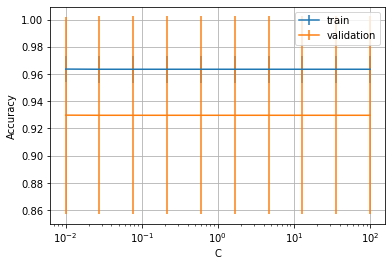

In [ ]:
C_grid = np.logspace(-2,2,10)

time_start = timer()
kf = StratifiedKFold(n_splits=5)

## Your code here
logit = linear_model.LogisticRegression(max_iter=5000, solver='sag')

train_scores, val_scores= validation_curve(logit, X1_train_v1, y1_train_v1, param_name='C', param_range=C_grid, cv = kf)
                          
time_end = timer()

print ("Wall time for training & cross-validation: {0} second".format(time_end-time_start))

ax = plot_cv_curve(C_grid,train_scores,val_scores)
ax.set_xlabel('C')
ax.set_ylabel('Accuracy')
ax.set_xscale('log')

In [ ]:
y1_pred = LogRegModel.predict(X1_test) 
#Print classification report 
print("Classification report for classifier %s:\n%s\n" % (LogRegModel, metrics.classification_report(y1_test, y1_pred)))

Classification report for classifier LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False):
              precision    recall  f1-score   support

           0       0.68      0.97      0.80    131318
           1       0.70      0.12      0.21     68682

    accuracy                           0.68    200000
   macro avg       0.69      0.55      0.51    200000
weighted avg       0.69      0.68      0.60    200000




In [ ]:
ConfusionMatrix=pd.DataFrame(confusion_matrix(y1_test, y1_pred)
  ,columns=['Predicted 0','Predicted 1'],index=['Actual 0','Actual 1']) 
print ('Confusion matrix of test data is: \n',ConfusionMatrix)

Confusion matrix of test data is: 
           Predicted 0  Predicted 1
Actual 0       127689         3629
Actual 1        60174         8508


In [ ]:
# calculate the fpr and tpr for all thresholds of the classification
probs = LogRegModel.predict_proba(X1_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y1_test, preds)
roc_auc = metrics.auc(fpr, tpr)

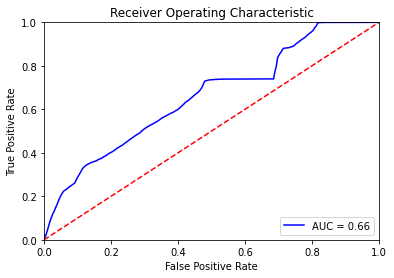

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## I.10 Model Comparison

In [ ]:
'''columns = ['LR', 'LASSO', 'ELN', 'RF']
index = ['r2', 'r2 standard deviation']
performance_df = pd.DataFrame(columns = columns, index = index)

models = []
#models.append(('RIDGE', Ridge()))
models.append(('LR', linear_model.LogisticRegression(solver = 'newton-cg', multi_class='multinomial')))
models.append(('RF', ensemble.RandomForestRegressor()))
scoring = 'r2'

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X1_train, y1_train,  cv=kfold, scoring=scoring)
    performance_df[name]['r2']=cv_results.mean()
    performance_df[name]['r2 standard deviation']=cv_results.std()
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    '''

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:426: LineSearchWarning: Roundin

LR: -0.631834 (1.317366)
RF: -0.760698 (2.688276)


# II. Impressions to clicks

## II.1. X1/y1
encoded version 1 training dataset


In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt 
import seaborn as sns

com_ad = pd.read_csv('final_training_testing_stratified.csv') # not sure how to update path
com_ad.drop(['Unnamed: 0'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# fillna with 0 to indicate if a specific label exists
com_ad[['10006','10024', '10031', '10048', '10052', '10057', '10059', '10063', '10067',
       '10074', '10075', '10076', '10077', '10079', '10083', '10093', '10102',
       '10110', '10111', '10684', '11092', '11278', '11379', '11423', '11512',
       '11576', '11632', '11680', '11724', '11944', '13042', '13403', '13496',
       '13678', '13776', '13800', '13866', '13874', '14273', '16593', '16617',
       '16661', '16706']] = com_ad[['10006','10024', '10031', '10048', '10052', '10057', '10059', '10063', '10067',
       '10074', '10075', '10076', '10077', '10079', '10083', '10093', '10102',
       '10110', '10111', '10684', '11092', '11278', '11379', '11423', '11512',
       '11576', '11632', '11680', '11724', '11944', '13042', '13403', '13496',
       '13678', '13776', '13800', '13866', '13874', '14273', '16593', '16617',
       '16661', '16706']].fillna(0)

In [ ]:
# keep information only related to the model from impression to click
# drop City ID because it's more than Region ID and highlt related to the Region ID
# drop Log Type because it's a constant given impression == 1

ad_imp = com_ad[['Ad Exchange',
       'Ad Slot Width', 'Ad Slot Height', 'Ad Slot Visibility',
       'Ad Slot Format', 'Ad Slot Floor Price', 'Bidding Price',
       'Advertiser ID', 'Timestamp_imp', 'Paying Price',
       'Region ID_bids_join_impressions', 'n_clicks', 'has impression', 'has click', '10006',
       '10024', '10031', '10048', '10052', '10057', '10059', '10063', '10067',
       '10074', '10075', '10076', '10077', '10079', '10083', '10093', '10102',
       '10110', '10111', '10684', '11092', '11278', '11379', '11423', '11512',
       '11576', '11632', '11680', '11724', '11944', '13042', '13403', '13496',
       '13678', '13776', '13800', '13866', '13874', '14273', '16593', '16617',
       '16661', '16706']]

# filter has impression == 1 to get the suitable dataset
ad_imp2clk = ad_imp[ad_imp['has impression']==1]
print(ad_imp2clk.shape)
ad_imp2clk.head()

(182812, 58)


,Ad Exchange,Ad Slot Width,Ad Slot Height,Ad Slot Visibility,Ad Slot Format,Ad Slot Floor Price,Bidding Price,Advertiser ID,Timestamp_imp,Log Type,Paying Price,Region ID_clicks,n_clicks,has impression,has click,10006,10024,10031,10048,10052,10057,10059,10063,10067,10074,10075,10076,10077,10079,10083,10093,10102,10110,10111,10684,11092,11278,11379,11423,11512,11576,11632,11680,11724,11944,13042,13403,13496,13678,13776,13800,13866,13874,14273,16593,16617,16661,16706
0,2,336,280,2,0,5,300,3386,2.013061e+16,1.0,5.0,NaN,NaN,1,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,728,90,2,0,5,300,1458,2.013061e+16,1.0,171.0,NaN,NaN,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,950,90,1,1,0,227,3427,2.013061e+16,1.0,119.0,106.0,1.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,300,250,2,0,5,238,3358,2.013061e+16,1.0,126.0,NaN,NaN,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2,728,90,2,0,5,300,1458,2.013061e+16,1.0,74.0,NaN,NaN,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# set ad exchange as object to get dummy variables
ad_imp2clk['Ad Exchange'] = ad_imp2clk['Ad Exchange'].astype('object')
# set ad slot visibility as object to get dummy variables
ad_imp2clk['Ad Slot Visibility'] = ad_imp2clk['Ad Slot Visibility'].astype('object')
# set ad slot format as object to get dummy variables
ad_imp2clk['Ad Slot Format'] = ad_imp2clk['Ad Slot Format'].astype('object')
# set advertiser id as object to get dummy variables
ad_imp2clk['Advertiser ID'] = ad_imp2clk['Advertiser ID'].astype('object')
# set region id as object to get dummy variables
ad_imp2clk['Region ID_bids_join_impressions'] = ad_imp2clk['Region ID_bids_join_impressions'].astype('object')

# convert region id into dummy variables
ad_imp2clk_enc = pd.get_dummies(ad_imp2clk, columns = ['Ad Exchange', 'Ad Slot Visibility','Ad Slot Format','Region ID_bids_join_impressions','Advertiser ID'])
ad_imp2clk_enc.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

,Ad Slot Width,Ad Slot Height,Ad Slot Floor Price,Bidding Price,Timestamp_imp,Log Type,Paying Price,n_clicks,has impression,has click,10006,10024,10031,10048,10052,10057,10059,10063,10067,10074,10075,10076,10077,10079,10083,10093,10102,10110,10111,10684,11092,11278,11379,11423,11512,11576,11632,11680,11724,11944,...,Ad Slot Format_0,Ad Slot Format_1,Ad Slot Format_5,Region ID_clicks_0.0,Region ID_clicks_1.0,Region ID_clicks_2.0,Region ID_clicks_3.0,Region ID_clicks_15.0,Region ID_clicks_27.0,Region ID_clicks_40.0,Region ID_clicks_55.0,Region ID_clicks_65.0,Region ID_clicks_79.0,Region ID_clicks_80.0,Region ID_clicks_94.0,Region ID_clicks_106.0,Region ID_clicks_124.0,Region ID_clicks_134.0,Region ID_clicks_146.0,Region ID_clicks_164.0,Region ID_clicks_183.0,Region ID_clicks_201.0,Region ID_clicks_216.0,Region ID_clicks_238.0,Region ID_clicks_253.0,Region ID_clicks_275.0,Region ID_clicks_276.0,Region ID_clicks_298.0,Region ID_clicks_308.0,Region ID_clicks_333.0,Region ID_clicks_344.0,Region ID_clicks_368.0,Region ID_clicks_374.0,Region ID_clicks_393.0,Region ID_clicks_394.0,Advertiser ID_1458,Advertiser ID_3358,Advertiser ID_3386,Advertiser ID_3427,Advertiser ID_3476
0,336,280,5,300,2.013061e+16,1.0,5.0,NaN,1,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,728,90,5,300,2.013061e+16,1.0,171.0,NaN,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,950,90,0,227,2.013061e+16,1.0,119.0,1.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,300,250,5,238,2.013061e+16,1.0,126.0,NaN,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6,728,90,5,300,2.013061e+16,1.0,74.0,NaN,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
# use earlier five days as training data 
imp_train_enc = ad_imp2clk_enc[ad_imp2clk_enc['Timestamp_imp']<20130611000000000]
# use the following two days as testing data
imp_test_enc = ad_imp2clk_enc[ad_imp2clk_enc['Timestamp_imp'] >= 20130611000000000]

In [ ]:
# training set
X1_train = imp2clk_train.drop('has click', axis=1)
y1_train = imp2clk_train[['has click']]

In [ ]:
# testing set
X1_test = imp2clk_test.drop('has click', axis=1)
y1_test = imp2clk_test[['has click']]

## II.2. Baseline Model

In [ ]:
# baseline model
train_clk = np.sum(imp2clk_train['has click']==1)
train_not_clk = np.sum(imp2clk_train['has click']==0)

print(pd.Series({'0': train_not_clk, '1': train_clk}))

# baseline model should predict not click for all observations in the test set

0    114041
1        89
dtype: int64


In [ ]:
# baseline model prediction probability
baseline_clk_prob = train_clk / (train_clk + train_not_clk)
baseline_clk_prob

0.9992201875054763

## II.3. Logistic Regression

In [ ]:
# logistic regression model from linear_model
from sklearn import linear_model
logreg2 = linear_model.LogisticRegression(max_iter=50000000,C=0.1, solver='saga',penalty='l2')
logreg2 = logreg2.fit(X1_train,y1_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
# predict the label/class
y1_logreg_label= logreg2.predict(X1_test)
# make probability predictions
y1_logreg_prob = logreg2.predict_proba(X1_test)[:,1]

In [ ]:
# log_loss(y_true, y_pred)
# y_true: true labels
# y_pred: Predicted probabilities

# cross entropy for logistic regression
from sklearn.metrics import log_loss
ce_logreg = log_loss(y1_test, y1_logreg_prob)
print('ce_logreg is: ', ce_logreg)

# cross entropy for baseline model
y1_base_label = [0] * len(y1_test)
y1_base_prob = [baseline_clk_prob] * len(y1_test)
ce_baseline = log_loss(y1_test, y1_base_prob)
print('ce_baseline is: ', ce_baseline)

# relative ce
ce_logregRatio = ce_logreg / ce_baseline
print('relative ce of logistic regression: ', ce_logregRatio)
ce_baselineRatio = ce_baseline / ce_baseline

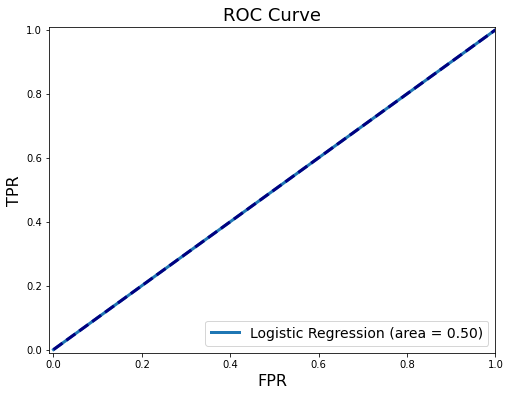

In [ ]:
# y_scorendarray of shape (n_samples,)
# Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of decisions

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y1_test, y1_logreg_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='Logistic Regression (area = {:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.legend(loc='lower right', fontsize=14)
plt.show()

## II.4. CART


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import time

grid_values = {'ccp_alpha': np.linspace(0, 0.10, 201),
               'min_samples_leaf': [5],
               'min_samples_split': [20],
               'max_depth': [30],
#                'class_weight' : [{0: 1, 1: 20}],
               'random_state': [88]} 

tic = time.time()

dtc = DecisionTreeClassifier()
dtc_cv_logloss = GridSearchCV(dtc, param_grid = grid_values,scoring='neg_log_loss', cv=10, verbose=2) 
dtc_cv_logloss.fit(X1_train, y1_train)

toc = time.time()
print('time:', round(toc-tic, 2),'s')

In [ ]:
logloss = dtc_cv_logloss.cv_results_['mean_test_score'] # what sklearn calls mean_test_score is the holdout set, i.e. the validation set.
ccp = dtc_cv_logloss.cv_results_['param_ccp_alpha'].data

plt.figure(figsize=(8, 6))
plt.xlabel('ccp alpha', fontsize=16)
plt.ylabel('mean validation default for decision tree', fontsize=16)
plt.scatter(ccp, logloss, s=2)
plt.plot(ccp, logloss, linewidth=3)
plt.grid(True, which='both')
plt.show()

## II.5. Random Forest

In [ ]:
# find suitable parameters
# other parameters are given in 242 lab

import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

grid_values = {'max_features': np.linspace(1,100,100, dtype='int32'),
               'min_samples_leaf': [5],
               'max_depth':[30],
               'n_estimators': [500],
               'random_state': [88]} 

tic = time.time()

rf2 = RandomForestClassifier() 
rf_cv = GridSearchCV(rf2, param_grid=grid_values, scoring='neg_log_loss', cv=5, verbose=2)
rf_cv.fit(X1_train, y1_train)

toc = time.time()

print('time:', round(toc-tic, 2),'s')

In [ ]:
y1_rf_cv_prob = rf_cv.best_estimator_.predict_proba(X1_test)
ce_rf_cv = log_loss(y1_test, y1_rf_cv_prob[:,1])

# relative cross entropy
ce_rf_cvRatio = ce_rf_cv / ce_baseline
print('ce_rf_cvRatio is: ', ce_rf_cvRatio)

In [ ]:
fpr5, tpr5, _ = roc_curve(y1_test, y1_rf_cv_prob[:,1])
roc_auc5 = auc(fpr5, tpr5)
plt.figure(figsize=(8, 6))
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr5, tpr5, lw=3, label='Random Forest (area = {:0.2f})'.format(roc_auc5))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.legend(loc='lower right', fontsize=14)
plt.show()

## Below is the code from Armand

## II.1. X2/y2 

In [ ]:
features2=df.drop(['has click' #target
  , 'n_clicks' #target 1:1
  , 'User Profile IDs_bid' #useless
  , 'User Profile IDs_imp' #redundant with dummification
  , 'Timestamp_bid'
  , 'Timestamp_imp'
  , 'Timestamp' #related to click
  , 'User-Agent' #related to click
  , 'User Profile IDs' #related to click
  , 'Region ID_clicks' #related to click
  , 'Log Type' #useless in our data format 
  , 'n_impressions'

  , 'User-Agent_bid' # for now let's ignore this as string too complex
  , 'User-Agent_imp' # for now let's ignore this as string too complex
  ], axis=1).columns
target2='has click'

In [ ]:
#df[features2].isna().sum() --> we can fill na with 0 as there are some only for paying price and null profile ids

X2_train = train[features2].fillna(0)
X2_test = test[features2].fillna(0)

y2_train = train[target2]
y2_test = test[target2]

print('X2_train:', X2_train.shape
      , '\nX2_test: ', X2_test.shape 
      , '\ny2_train:', y2_train.shape
      , '\ny2_test: ', y2_test.shape)

X2_train: (500000, 55) 
X2_test:  (200000, 55) 
y2_train: (500000,) 
y2_test:  (200000,)


In [ ]:
X2_train.head()

,Region ID_bids_join_impressions,City ID,Ad Exchange,Ad Slot Width,Ad Slot Height,Ad Slot Visibility,Ad Slot Format,Ad Slot Floor Price,Bidding Price,Advertiser ID,Paying Price,has impression,10006,10024,10031,10048,10052,10057,10059,10063,10067,10074,10075,10076,10077,10079,10083,10093,10102,10110,10111,10684,11092,11278,11379,11423,11512,11576,11632,11680,11724,11944,13042,13403,13496,13678,13776,13800,13866,13874,14273,16593,16617,16661,16706
0,80,85,2,336,280,2,0,5,300,3386,5.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,15,23,2,300,250,2,0,5,238,3358,126.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,80,81,2,336,280,2,0,5,238,3358,72.0,1,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,94,100,1,300,250,1,1,0,227,3358,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,333,341,1,300,250,2,1,0,227,3358,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## II.2. Baseline Model-v1

In [ ]:
y2_train.value_counts() 

0    499910
1        90
Name: has click, dtype: int64

In [ ]:
y2_test.value_counts() 

0    199938
1        62
Name: has click, dtype: int64

In [ ]:
training_accuracy=len(y2_train[y2_train==0])/len(y2_train)
print ('Training Accuracy:',training_accuracy)

Training Accuracy: 0.99982


In [ ]:
testing_accuracy=len(y2_test[y2_test==0])/len(y2_test)
print ('Testing Accuracy:',testing_accuracy)

Testing Accuracy: 0.99969


In [ ]:
## II.2. Base

## II.3. Logistic Regression

In [ ]:
LogRegModel = linear_model.LogisticRegression(max_iter=100)
LogRegModel = LogRegModel.fit(X2_train,y2_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
training_accuracy=LogRegModel.score(X2_train,y2_train)
print ('Training Accuracy:',training_accuracy)
test_accuracy = LogRegModel.score(X2_test,y2_test) 
print('Accuracy of the model on unseen test data: ', test_accuracy)

Training Accuracy: 0.99982
Accuracy of the model on unseen test data:  0.99969


In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc =DecisionTreeClassifier(max_depth=10, max_features='log2',random_state=0).fit(X1_train2, y1_train)
dtc.predict_proba(X1_train2)

NameError: ignored

In [ ]:
X2_train.shape

# III. Fairlearn

In [ ]:
#!pip install fairlearn
import fairlearn 

In [ ]:
print(X1_train_v1.shape)
print(X1_test_v1.shape)
print(y1_train_v1.shape)
print(y1_test_v1.shape)

training_accuracy=len(X1_train_v1[y1_train_v1==0])/len(y1_train_v1)
print ('Training Accuracy:',training_accuracy)

testing_accuracy=len(y1_test_v1[y1_test_v1==0])/len(y1_test_v1)
print ('Training Accuracy:',testing_accuracy)

NameError: ignored

In [ ]:
X1_train_v1.drop(['exact_time', 'User-Agent_bid'], axis=1, inplace=True)
X1_test_v1.drop(['exact_time', 'User-Agent_bid'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
X1_train_v1.head()

,Region ID_bids_join_impressions,City ID,Ad Exchange,Ad Slot Width,Ad Slot Height,Ad Slot Visibility,Ad Slot Format,Ad Slot Floor Price,Bidding Price,Advertiser ID
0,80,85,2,336,280,2,0,5,300,3386
4,15,23,2,300,250,2,0,5,238,3358
11,80,81,2,336,280,2,0,5,238,3358
18,94,100,1,300,250,1,1,0,227,3358
20,333,341,1,300,250,2,1,0,227,3358


In [ ]:
time_start = timer()
LogRegModel = linear_model.LogisticRegression(solver='lbfgs', max_iter=5000)
LogRegModel = LogRegModel.fit(X1_train_v1,y1_train_v1)
time_end= timer()
print ("Wall time for training logit: %s second"%(time_end-time_start))

training_accuracy=LogRegModel.score(X1_train_v1,y1_train_v1)
print ('Training Accuracy:',training_accuracy)
test_accuracy = LogRegModel.score(X1_test_v1,y1_test_v1) 
print('Accuracy of the model on unseen test data: ', test_accuracy)

Wall time for training logit: 1.0000319230020978 second
Training Accuracy: 0.9625
Accuracy of the model on unseen test data:  0.82


In [ ]:
X1_train_v1.head(2)

,Region ID_bids_join_impressions,City ID,Ad Exchange,Ad Slot Width,Ad Slot Height,Ad Slot Visibility,Ad Slot Format,Ad Slot Floor Price,Bidding Price,Advertiser ID
0,80,85,2,336,280,2,0,5,300,3386
4,15,23,2,300,250,2,0,5,238,3358


In [ ]:
from raiwidgets import FairnessDashboard

FairnessDashboard(y_true = y1_test_v1,
                   y_pred = LogRegModel.predict(X1_test_v1),
                   sensitive_features = X1_test_v1['City ID']
                   #sensitive_feature_names = ["City ID"]
                  )

Output hidden; open in https://colab.research.google.com to view.